## Problem Set 2: Merging and regular expressions

**Total points (without extra credit)**: 30 

**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset2_inputdata` (need to unzip): 

- `jobs_clean`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


You can view a codebook here: https://docs.google.com/spreadsheets/d/1rF9GJEC8pPKxipD0TsoG9DVdqz3EJ-b-BHEtyioAX7I/edit?usp=sharing


In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import os

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Reshaping data (13 points total)

Load the following dataset stored in `pset2_inputdata`: `debar.csv`

This represents employers temporarily banned from hiring workers (debar.csv); call this `debar`


View the head()


In [2]:
debar = pd.read_csv('/Users/humberto/Downloads/pset2_inputdata/debar.csv')
print(debar.head())


                               Name     City, State  \
0                    J&J Harvesting       Leads, ND   
1            Stahlman Apiaries, Inc       Selby, SD   
2                     Trust Nursery     Pulaski, NY   
3             Anton Fertilizer Inc.     Dighton, KS   
4  Great Plains Fluid Service, Inc.  Greensburg, KS   

                                        Violation Duration Start date  \
0  Failure to respond to audit (partial response)  2 years  1/19/2014   
1  Failure to respond to audit (partial response)   1 year  2/19/2015   
2  Failure to respond to audit (partial response)   1 year  3/21/2014   
3       Failure to respond to audit (no response)  2 years  3/30/2014   
4       Failure to respond to audit (no response)  2 years  3/30/2014   

    End date  
0  1/18/2016  
1  2/14/2016  
2  3/20/2015  
3  3/29/2016  
4  3/29/2016  


## 1.1 (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [3]:
total_rows = len(debar)

# Calculate the number of unique employer names
unique_employers = debar['Name'].nunique()

print("Total number of rows in the dataset:", total_rows)
print("Number of unique employer names:", unique_employers)

# Determine if there is one row per employer or multiple
if total_rows == unique_employers:
    print("There is one row per employer.")
else:
    print("There are multiple rows for some employers.")

Total number of rows in the dataset: 114
Number of unique employer names: 98
There are multiple rows for some employers.


## There are multiple rose for some employers


## 1.2 Investigating duplicated rows (2 points)

A. Create a new column in `debar`--`is_repeated`-- that tells us whether an employer (`Name`) is repeated > 1 times

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using value_counts() on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [4]:
# Step A
name_counts = debar['Name'].value_counts()
debar['is_repeated'] = debar['Name'].map(name_counts) > 1

# Step B
print("Rows where 'is_repeated' is True:")
repeated_rows = debar[debar['is_repeated']]
print(repeated_rows)

# Step C
mult_debar = debar[debar['is_repeated']]
print("Head of the dataset with multiple entries for the same employer:")
print(mult_debar.head())
print( mult_debar.shape)

Rows where 'is_repeated' is True:
                                        Name       City, State  \
6                    Annabella Land & Cattle     Annabella, UT   
7                        Autumn Hill Orchard        Groton, MA   
8      Caddo Creek Ranch, dba Paradise Ranch         Caddo, TX   
11                     Loewen Harvesting LLC   Brownsville, TX   
12               Rollo Farm Labor Contractor         Miami, FL   
14                             Sharon Mathis        Tifton, GA   
15                                 SRT Farms        Morton, TX   
16                               Mark Duncan     Roosevelt, UT   
17          Maple Ridge Custom Services, LLC     Altheimer, AK   
18                                 F&W Farms       Ingalls, KS   
19                        Cisco Produce Inc.         Cairo, GA   
21   Old Tree Farms/Verpaalen Custom Service         Volga, SD   
24               Rollo Farm Labor Contractor         Miami, FL   
25                     Loewen Harvesting L

## 1.3 Reshape mult_debar to wide to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in this data (eg converting `Violation` to lowercase; replacing spelled-out states with two-dig state codes)

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

Print the head and shape

In [5]:
# Create an identifier combining Name and City, State
mult_debar['Identifier'] = mult_debar['Name'] + ', ' + mult_debar['City, State']

# Sort the data to ensure consistent column filling
mult_debar_sorted = mult_debar.sort_values(by=['Identifier', 'Start date'])

# Pivot the data to wide format
mult_debar_sorted['Violation_Number'] = mult_debar_sorted.groupby('Identifier').cumcount() + 1
mult_debar_wide = mult_debar_sorted.pivot(index='Identifier', columns='Violation_Number', values='Start date')

# Rename the columns for clarity
mult_debar_wide.columns = [f'start_date_viol{col}' for col in mult_debar_wide.columns]

# Print the head and the shape of the wide dataframe
print("Head of mult_debar_wide:")
print(mult_debar_wide.head())
print("Shape of mult_debar_wide:", mult_debar_wide.shape)
mult_debar_wide


Head of mult_debar_wide:
                                                   start_date_viol1  \
Identifier                                                            
Annabella Land & Cattle, Annabella, UT                     5/9/2014   
Annabella Land & Cattle, Annabella, Utah                   5/9/2014   
Autumn Hill Orchard, Groton, MA                            7/6/2014   
Caddo Creek Ranch, dba Paradise Ranch, Caddo, TX          7/20/2014   
Caddo Creek Ranch, dba Paradise Ranch, Caddo, T...        7/20/2014   

                                                   start_date_viol2  
Identifier                                                           
Annabella Land & Cattle, Annabella, UT                          NaN  
Annabella Land & Cattle, Annabella, Utah                        NaN  
Autumn Hill Orchard, Groton, MA                            7/6/2014  
Caddo Creek Ranch, dba Paradise Ranch, Caddo, TX                NaN  
Caddo Creek Ranch, dba Paradise Ranch, Caddo, T...       

/var/folders/7k/m82xdk_17rv8945q1gt3mmhr0000gn/T/ipykernel_88158/274220866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mult_debar['Identifier'] = mult_debar['Name'] + ', ' + mult_debar['City, State']


,start_date_viol1,start_date_viol2
Identifier,,
"Annabella Land & Cattle, Annabella, UT",5/9/2014,NaN
"Annabella Land & Cattle, Annabella, Utah",5/9/2014,NaN
"Autumn Hill Orchard, Groton, MA",7/6/2014,7/6/2014
"Caddo Creek Ranch, dba Paradise Ranch, Caddo, TX",7/20/2014,NaN
"Caddo Creek Ranch, dba Paradise Ranch, Caddo, Texas",7/20/2014,NaN
"Cisco Produce Inc., Cairo, GA",12/10/2014,12/10/2015
"Dove Creek Farms, Mount Vernon, TX",2/9/2018,2/9/2018
"F&W Farms, Ingalls, KS",12/10/2014,12/10/2014
"Loewen Harvesting LLC, Brownfield, TX",8/20/2014,NaN


## 1.4 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning- `debar`
    - For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == viol1`
    - For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
    - Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

In [22]:
debar['Violation_Number'] = debar.groupby('Identifier').cumcount() + 1

# A. Identify duplicates
mult_debar_wide['is_dup'] = mult_debar_wide['start_date_viol1'] == mult_debar_wide['start_date_viol2']

# Create a DataFrame to capture identifiers (employers) with duplicates
identifiers_with_duplicates = mult_debar_wide[mult_debar_wide['is_dup']].index

# B. Filter the original debar data
# Create a boolean mask for entries to keep
keep_mask = debar['Identifier'].isin(identifiers_with_duplicates) & (debar['Violation_Number'] == 1)
keep_all_others = ~debar['Identifier'].isin(identifiers_with_duplicates)

# Use pd.concat to combine filtered entries
debar_clean = pd.concat([debar[keep_mask], debar[keep_all_others]])

# Remove the 'is_repeated' column
debar_clean.drop(columns='is_repeated', inplace=True)

# Print the shape and number of unique employer names in the cleaned data
print("Shape of debar_clean:", debar_clean.shape)
print("Number of unique employer names:", debar_clean['Name'].nunique())


Shape of debar_clean: (105, 8)
Number of unique employer names: 98


# 2. Merging and regex (17 points total)



## 2.1 Load data on job postings

The previous dataset contains a small subset of employers who faced temporary bans due to violations of H-2A program regulations

Since most of the bans have expired, we're going to see which of those employers posted new H-2A jobs in the first quarter of 2021 

Loading the `jobs_clean.csv` data stored in `pset4_inputdata`

In [31]:
jb  = pd.read_csv('/Users/humberto/Downloads/pset2_inputdata/jobs.csv')
jb.head()


,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"Fazio Farms Operating Company, LLC",NaN,...,N,1,Y,12.68,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,Charlie Sunderland,Panter & Sunderland Nursery,...,N,1,N,NaN,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Michael Rudebusch,NaN,...,N,1,N,NaN,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Lodahl Farms,NaN,...,Y,2,N,NaN,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"Dunson Harvesting, Inc.","Dunson Harvesting, Inc.",...,Y,8,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4


##  2.2 Try inner join on employer name  (2 points)

- Use the `EMPLOYER_NAME` field of the `jobs` dataset
- Use the `Name` field of the `debar_clean` dataset 

A. Use pd.merge with an inner join on those fields to see whether there are any exact matches. 

B. If there are exact matches, print the row(s) with exact matches



In [32]:
## merge the two data sets 
jb['EMPLOYER_NAME']
debar_clean['Name']
merged = pd.merge(jb, debar_clean, left_on=['EMPLOYER_NAME'], right_on=[ 'Name'], how='inner')
merged
print('One exact match!')

0       Fazio Farms Operating Company, LLC
1                       Charlie Sunderland
2                        Michael Rudebusch
3                             Lodahl Farms
4                  Dunson Harvesting, Inc.
                       ...                
2715                     James L Schneller
2716                       Stephen G Myers
2717                            Andy Povey
2718                Silver Creek Seed, LLC
2719                        Halabura Farms
Name: EMPLOYER_NAME, Length: 2720, dtype: object

7                                    Autumn Hill Orchard
12                           Rollo Farm Labor Contractor
14                                         Sharon Mathis
15                                             SRT Farms
16                                           Mark Duncan
                             ...                        
107                                         Walker Place
108    County Fair Farm (company) and Andrew Williams...
110                                        Jesus Ledesma
112          B & R Harvesting and Paul Cruz (individual)
113                                          Delia Rojas
Name: Name, Length: 105, dtype: object

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,Name,"City, State",Violation,Duration,Start date,End date,Identifier,Violation_Number,name_clean,name_clean_2
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,Rafael Barajas,NaN,...,Rafael Barajas,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,"Rafael Barajas, Sebring, Florida",1.0,Rafael Barajas,Rafael Barajas


One exact match!


## 2.3 Targeted regex (10 points total)

You want to see if you can increase the exact match rate with some basic cleaning of each 
of the employer name fields in each dataset 

### 2.3.1 Converting to upper (2 points)

A. Convert the `EMPLOYER_NAME` and `Name` fields to uppercase using list comprehension rather than df.varname.str.upper() (it's fine to do a separate list comprehension line for each of the two columns)

B. Print a random sample of 15 values of each result

C. Assign the full vector of uppercase names back to the original data, writing over the original `EMPLOYER_NAME` and `Name` columns 


In [33]:
## insert your code to turn into uppercase here
jb.loc[:,'EMPLOYER_NAME'] = list(map(lambda x: x.upper(), jb['EMPLOYER_NAME']))
debar_clean.loc[:,'Name'] = list(map(lambda x: x.upper(), debar_clean['Name']))
jb['EMPLOYER_NAME'].sample(n=15)
debar_clean['Name'].sample(n=15)


682             FRESH HARVEST, INC.
2655                  CELTIC L, LLC
808                   RHEA BROTHERS
2582       EVERGREEN PROPERTIES LLC
1193           CONNELLY ANGUS, INC.
568                   SMYTHE & SONS
2006      WESTERN RANGE ASSOCIATION
748     HINEMAN LAND & CATTLE, INC.
389              PGM PACKING, INC. 
386                MARK JOYCE RANCH
2642         WICKMAN GARDEN VILLAGE
534             VAN ZYVERDEN, INC. 
33                     PHIL WALTERS
794           LA THERIOT FARMS, LLC
2473             TETON MOTORS, INC.
Name: EMPLOYER_NAME, dtype: object

21     OLD TREE FARMS/VERPAALEN CUSTOM SERVICE
76                            ROBERT D. TOWLES
65                                 DONNA LUCIO
0                               J&J HARVESTING
96                            NEMORIO RESENDIZ
100                          EVERGREEN PRODUCE
93                            DEAL FAMILY FARM
27                      YOLANDA CHAVEZ FARMING
13                               REIMER'S INC.
36                                 AGECY I LLC
75                       C HANGING L RANCH LLP
41                             K W ENTERPRISES
33                          GERONIMO SHEEP CO.
2                                TRUST NURSERY
45                         GLENDA HARROD FARMS
Name: Name, dtype: object

### 2.3.2 Cleaning up punctuation (4 points)

You notice that INC, CO, and LLC are sometimes followed by a period (.) but sometimes not

A. For each dataset, write a regex pattern using `re.sub` to remove the . but only if it's preceded by INC, LLC, or CO 

Make sure LLC, INC, CO remain part of the string but just without the dot

B. Test the pattern on the positive and negative example we provide below and print the result. See the Github issue for examples of what to return


**Hint**: https://stackoverflow.com/questions/7191209/python-re-sub-replace-with-matched-content



In [34]:
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP"

In [35]:
## insert your code here with the regex pattern for part A
pos_example_1 = "CISCO PRODUCE INC."
pattern = r"(INC\.|CO\.|LLC\.)"

## insert your code to use re.sub to apply the pattern to the test cases for part B
pract_1 = re.sub(pattern, lambda x: x.group().replace('.', ''), pos_example_1);pract_1
pract_2 = re.sub(pattern, lambda x: x.group().replace('.', ''), pos_example_2); pract_2
pract_3 = re.sub(pattern, lambda x: x.group().replace('.', ''), neg_example); pract_3

'CISCO PRODUCE INC'

'AVOYELLES HONEY CO, LLC'

'E.V. RANCH LLP'

### 2.3.3 (4 points)

Use that pattern in conjunction with `re.sub` and list comprehension to clean the employer name columns in each dataset. Save the new columns as `name_clean` in each. Then, use row subsetting to (1) subset to rows that changed names and (2) for:

- `debar_clean` print the `Name` and `name_clean` columns
- `jobs` print the `EMPLOYER_NAME` and `name_clean` columns

Make sure to use the uppercase versions of the variables


In [36]:
jb['name_clean'] = [re.sub(pattern, lambda x: x.group().replace('.', ''), name)
                         for name in jb.EMPLOYER_NAME]
jb['name_clean']
debar_clean['name_clean'] = [re.sub(pattern, lambda x: x.group().replace('.', ''), name)
                         for name in debar_clean.Name]
# Subset to only those names which changed
debar_changed_names = debar_clean[debar_clean['name_clean'] != debar_clean['Name'].str.upper()]
jb_changed_names = jb[jb['name_clean'] != jb['EMPLOYER_NAME'].str.upper()]

# Print the desired columns showing both original and cleaned names
print("Changed Names in debar_clean:")
print(debar_changed_names[['Name', 'name_clean']])

print("\nChanged Names in jb (jobs_clean):",jb_changed_names[['EMPLOYER_NAME', 'name_clean']])


0       FAZIO FARMS OPERATING COMPANY, LLC
1                       CHARLIE SUNDERLAND
2                        MICHAEL RUDEBUSCH
3                             LODAHL FARMS
4                   DUNSON HARVESTING, INC
                       ...                
2715                     JAMES L SCHNELLER
2716                       STEPHEN G MYERS
2717                            ANDY POVEY
2718                SILVER CREEK SEED, LLC
2719                        HALABURA FARMS
Name: name_clean, Length: 2720, dtype: object

Changed Names in debar_clean:
                                Name                       name_clean
3              ANTON FERTILIZER INC.             ANTON FERTILIZER INC
4   GREAT PLAINS FLUID SERVICE, INC.  GREAT PLAINS FLUID SERVICE, INC
5                        PROMAX INC.                       PROMAX INC
13                     REIMER'S INC.                     REIMER'S INC
19                CISCO PRODUCE INC.                CISCO PRODUCE INC
23                     REIMER’S INC.                     REIMER’S INC
33                GERONIMO SHEEP CO.                GERONIMO SHEEP CO
46          ALTENDORF TRANSPORT INC.          ALTENDORF TRANSPORT INC
56                CISCO PRODUCE INC.                CISCO PRODUCE INC
72      SAXTONS RIVER ORCHARDS, INC.      SAXTONS RIVER ORCHARDS, INC
91          AVOYELLES HONEY CO., LLC          AVOYELLES HONEY CO, LLC

Changed Names in jb (jobs_clean):                                  EMPLOYER_NAME  \
4                      DUNSON HARVESTING, INC

## 2.4 More joins and more cleaning (5 points)

A. Conduct another inner join between `jobs` and `debar_clean` now using the `name_clean` column; print the result. Did the cleaning result in any more employers matched between the two datasets?

B. Create a new column in `debar_clean` called `name_clean_2` that uses regex to take the following name in that dataset:

- `SLASH E.V. RANCH LLP` in the `debar_clean` dataset

And cleans it up so that it matches with this employer in `jobs`

- `SLASH EV RANCH` in the `jobs` dataset

Eg a pattern to remove the dots in the EV and the space+LLP-- you can apply the pattern to all employer names in debar_clean (so don't need to worry about only applying it to that one employer)


C. Conduct a left join using `name_clean_2` as the join column where the left hand dataframe is `jobs`; right hand dataframe is `debar_clean`, store the result as a dataframe, and print the rows where the merge indicator indicates the row was found in both dataframe

**Note**: this manual cleaning process is inefficient and helps motivate why talked about fuzzy matching. Fuzzy matching could recognize that Slash EV ranch is a highly similar string to slash ev ranch llp and match them without us needing to use regex to make the strings identical.

In [37]:
## your code here
jb['name_clean']
debar_clean['name_clean']
second_merged =  pd.merge(jb, debar_clean, on=['name_clean'],how='inner')

second_merged
print('1 match') 

## Fix Slash ranch 
pattern = r'SLASH\s*E\.V\.\s*RANCH\s*LLP'
debar_clean['name_clean_2'] = [re.sub(pattern, 'SLASH EV RANCH', name) 
                    for name in debar_clean.name_clean] 
debar_clean['name_clean_2']

third_merged =  pd.merge(jb, debar_clean, left_on=['name_clean'], right_on=['name_clean_2'],how='inner')
third_merged

0       FAZIO FARMS OPERATING COMPANY, LLC
1                       CHARLIE SUNDERLAND
2                        MICHAEL RUDEBUSCH
3                             LODAHL FARMS
4                   DUNSON HARVESTING, INC
                       ...                
2715                     JAMES L SCHNELLER
2716                       STEPHEN G MYERS
2717                            ANDY POVEY
2718                SILVER CREEK SEED, LLC
2719                        HALABURA FARMS
Name: name_clean, Length: 2720, dtype: object

7                                    AUTUMN HILL ORCHARD
12                           ROLLO FARM LABOR CONTRACTOR
14                                         SHARON MATHIS
15                                             SRT FARMS
16                                           MARK DUNCAN
                             ...                        
107                                         WALKER PLACE
108    COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...
110                                        JESUS LEDESMA
112          B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL)
113                                          DELIA ROJAS
Name: name_clean, Length: 105, dtype: object

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,name_clean,Name,"City, State",Violation,Duration,Start date,End date,Identifier,Violation_Number,name_clean_2
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,RAFAEL BARAJAS,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,"Rafael Barajas, Sebring, Florida",1.0,Rafael Barajas


1 match


7                                    AUTUMN HILL ORCHARD
12                           ROLLO FARM LABOR CONTRACTOR
14                                         SHARON MATHIS
15                                             SRT FARMS
16                                           MARK DUNCAN
                             ...                        
107                                         WALKER PLACE
108    COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...
110                                        JESUS LEDESMA
112          B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL)
113                                          DELIA ROJAS
Name: name_clean_2, Length: 105, dtype: object

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,Name,"City, State",Violation,Duration,Start date,End date,Identifier,Violation_Number,name_clean_y,name_clean_2
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,"Rafael Barajas, Sebring, Florida",1.0,RAFAEL BARAJAS,RAFAEL BARAJAS
1,H-300-20306-894148,Determination Issued - Certification,2020-11-02 18:11:29.140,2020-11-24 00:00:00.000,Individual Employer,N,Seasonal,N,SLASH EV RANCH,NaN,...,SLASH E.V. RANCH LLP,"Rifle, CO",WHD Debarment,1 year,11/15/2014,11/14/2015,"Slash E.V. Ranch LLP, Rifle, CO",1.0,SLASH E.V. RANCH LLP,SLASH EV RANCH


# 3. Optional extra credit 1: regex to separate companies from individuals (1 point)

You notice some employers in `debar_clean` have both the name of the company and the name of individual, e.g.:
    
COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*

Use the uppercase/cleaned `name_clean` in `debar_clean`

A. Write a regex pattern that does the following:
    - Captures the pattern that occurs before COMPANY if (COMPANY) is in string; so in example above, extracts COUNTY FAIR FARM 
    - Captures the pattern that occurs before INDIVIDUAL if (INDIVIDUAL) is also in string -- so in above, extracts ANDREW WILLIAMSON (so omit the "and")
    
B. Test the pattern on `pos_example` and `neg_example`-- make sure former returns a list (if using find.all) or match object (if using re.search) with the company name and individual name separated out; make sure latter returns empty
    
**Hints and resources**: for step A, you can either use re.search, re.match, or re.findall; don't worry about matching B&R Harvesting and Paul Cruz (Individual)

- Same regex resources as above
    

In [38]:
pos_example = "COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*"
neg_example = "CISCO PRODUCE INC"

## your code here to define the pattern
pattern = r'(.+?) \(COMPANY\).*AND (.+?) \(INDIVIDUAL\)'

## your code here to apply it to the pos_example
match = re.search(pattern, pos_example)
if match:
    print("Match found:", match.groups())  
else:
    print("No match found")


## your code here to apply it to the negative example
match_neg = re.search(pattern, neg_example)
if match_neg:
    print("Match found in negative example:", match_neg.groups())
else:
    print("No match found in negative example") 

Match found: ('COUNTY FAIR FARM', 'ANDREW WILLIAMSON')
No match found in negative example


C. Iterate over the `name_clean` column in debar and use regex to create two new columns in `debar_clean`:
   - `co_name`: A column for company (full `name_clean` string if no match; pattern before COMPANY if one extracted)
   - `ind_name`: A column for individual (full `name_clean` string if no match; pattern before INDIVIDUAL if one extracted)
 


In [39]:
# your code here
debar_clean['co_name'] = ''
debar_clean['ind_name'] = ''
pattern_company = r'(.+?)\s*(\(COMPANY\))'
pattern_individual = r'AND\s*(.+?)\s*(\(INDIVIDUAL\))'

for index, row in debar_clean.iterrows():
    # Extract company name if "COMPANY" is present, else full string
    company_match = re.search(pattern_company, row['name_clean'])
    if company_match:
        debar_clean.at[index, 'co_name'] = company_match.group(1)
    else:
        debar_clean.at[index, 'co_name'] = row['name_clean']  # Default to full string if no COMPANY label

    # Extract individual name if "INDIVIDUAL" is present, else full string
    individual_match = re.search(pattern_individual, row['name_clean'])
    if individual_match:
        debar_clean.at[index, 'ind_name'] = individual_match.group(1)
    else:
        debar_clean.at[index, 'ind_name'] = row['name_clean']  # Default to full string if no INDIVIDUAL label

print(debar_clean[['name_clean', 'co_name', 'ind_name']])

                                            name_clean  \
7                                  AUTUMN HILL ORCHARD   
12                         ROLLO FARM LABOR CONTRACTOR   
14                                       SHARON MATHIS   
15                                           SRT FARMS   
16                                         MARK DUNCAN   
..                                                 ...   
107                                       WALKER PLACE   
108  COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...   
110                                      JESUS LEDESMA   
112        B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL)   
113                                        DELIA ROJAS   

                                         co_name                     ind_name  
7                            AUTUMN HILL ORCHARD          AUTUMN HILL ORCHARD  
12                   ROLLO FARM LABOR CONTRACTOR  ROLLO FARM LABOR CONTRACTOR  
14                                 SHARON MATHIS               

   
D. Print three columns for the rows in `debar_clean` containing the negative example and positive example described above (county fair farm and cisco produce):

- `name_clean`x
- `co_name`
- `ind_name`
- `Violation`

**Note**: as shown in the outcome there may be duplicates of the same company reflecting different violations

In [40]:
# your code here
filtered_rows = debar_clean[
    (debar_clean['co_name'].str.contains("COUNTY FAIR FARM", na=False)) |
    (debar_clean['co_name'].str.contains("CISCO PRODUCE", na=False)) |
    (debar_clean['ind_name'].str.contains("COUNTY FAIR FARM", na=False)) |
    (debar_clean['ind_name'].str.contains("CISCO PRODUCE", na=False))]

print(filtered_rows[['name_clean', 'co_name', 'ind_name', 'Violation']])


                                            name_clean            co_name  \
19                                   CISCO PRODUCE INC  CISCO PRODUCE INC   
56                                   CISCO PRODUCE INC  CISCO PRODUCE INC   
108  COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...   COUNTY FAIR FARM   

              ind_name                                   Violation  
19   CISCO PRODUCE INC   Failure to respond to audit (no response)  
56   CISCO PRODUCE INC  Impeding the Audit Process – Non- Response  
108  ANDREW WILLIAMSON                               WHD Debarment  


# 4. Optional extra credit 2 (up to 3 points)

- For 1 point extra credit, create a visualization with 1+ of the existing fields in either the raw `jobs` or `debar` data. We'll be showing cool visualizations in class so use your imagination! Options could include visualizing between-state or over-time variation

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia 
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data. 
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/ 
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1` 
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

<Figure size 1200x1000 with 0 Axes>

<Axes: xlabel='State'>

Text(0.5, 1.0, ' Violations by State')

Text(0.5, 0, 'State')

Text(0, 0.5, 'Number of Violations')

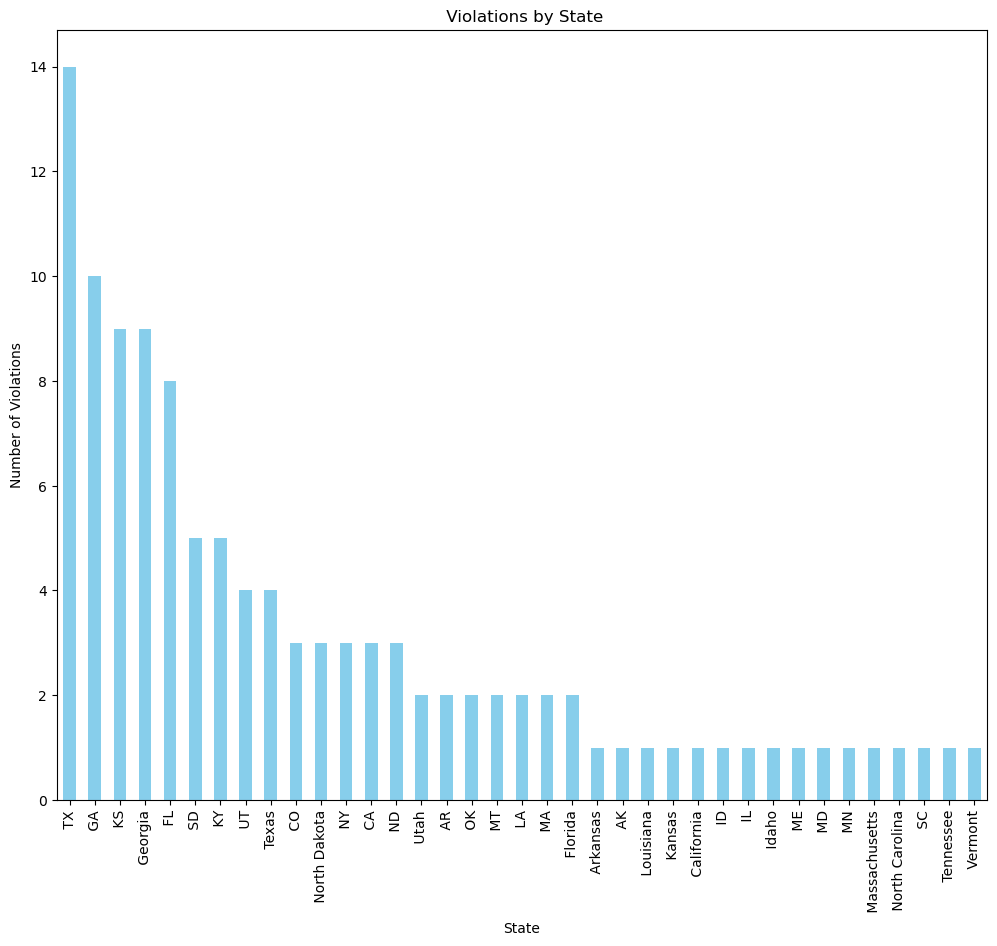

In [41]:
## your code here

debar[['City', 'State']] = debar['City, State'].str.split(',', expand=True)
state_violations = debar.groupby('State').size().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 10))
state_violations.plot(kind='bar', color='skyblue')
plt.title(' Violations by State')
plt.xlabel('State')
plt.ylabel('Number of Violations')
plt.show()

